# Libraries

In [194]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from textblob import TextBlob
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier








[nltk_data] Downloading package punkt_tab to /Users/haji/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/haji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/haji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/haji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

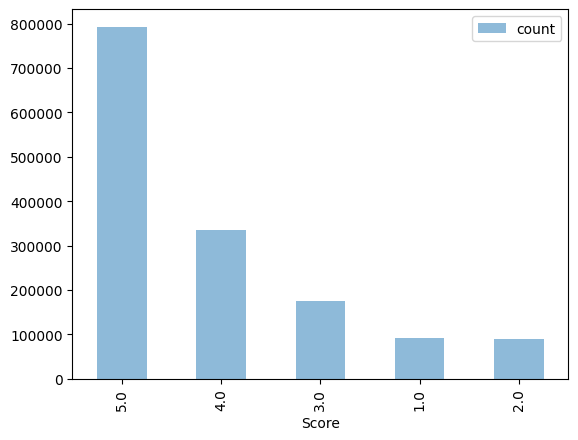


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [125]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

label_encoder = LabelEncoder()
trainingSet['UserId'] = label_encoder.fit_transform(trainingSet['UserId'])

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [201]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

def remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.lower() not in stop_words and t.isalpha()]
    return ' '.join(tokens)

def get_sentiment(text):
    if isinstance(text, float):
        text = str(text)
    text = remove_stopwords(text)
    blob = TextBlob(text)
    
    # Get the sentiment polarity
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    return (polarity, subjectivity)
    

def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Polarity'], df['Subjectivity'] = zip(*df['Text'].apply(get_sentiment))
    df['Polarity2'], df['Subjectivity2'] = zip(*df['Summary'].apply(get_sentiment))
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['WordCount'] = df['Text'].apply(lambda x: len(word_tokenize(x)) if isinstance(x, str) else 0)

    tfidf_matrix = tfidf.fit_transform(df['Text'].fillna(""))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
    
    # Combine original features with TF-IDF features
    df_combined = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
    
    return df_combined
    

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    trainingSet_sampled = trainingSet.sample(frac=0.02)
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [202]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=1,
    stratify=X_train['Score']
)

print(X_train.head())
print(X_test.head())

            Id   ProductId  UserId  HelpfulnessNumerator  \
6390    455990  6305248052   15577                     2   
24547   152499  0792845129   52358                     2   
32327  1659092  B00DL48BM6   17240                     0   
6073    967032  B000E33VWW   82377                     0   
16038   162706  0800129806   22243                     1   

       HelpfulnessDenominator        Time  \
6390                        3  1336953600   
24547                       5  1029801600   
32327                       0  1404000000   
6073                        0  1161648000   
16038                       2   998092800   

                                       Summary  \
6390                            Bland Transfer   
24547               "Dance, Muthafuka! Dance!"   
32327                        The Monuments Men   
6073   "Glistened like Christmas Tree Snow..."   
16038                    Not Exellent, Not Bad   

                                                    Text  Polarity 

# Feature Selection

In [203]:
def get_available_features(df, feature_list):
    return [f for f in feature_list if f in df.columns]
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'Polarity', "Polarity2" ,"Subjectivity", "Subjectivity2", 'WordCount', 'UserId']

# Apply feature selection
available_features_train = get_available_features(X_train, features)
available_features_test = get_available_features(X_test, features)
available_features_submission = get_available_features(X_submission, features)

# Select features from each dataset
X_train_select = X_train[available_features_train]
X_test_select = X_test[available_features_test]
X_submission_select = X_submission[available_features_submission]

rus = x(random_state=42)
smote = SMOTE(random_state=42)

X_resampled, y_resampled = rus.fit_resample(X_train_select, Y_train)
X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)

common_features = X_resampled.columns.intersection(X_test_select.columns)
X_resampled = X_resampled[common_features]
X_test_select = X_test_select[common_features]
X_submission_select = X_submission_select[common_features]

# Model Creation

In [204]:
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Learn the model
param_grid = {
    'n_estimators': [100, 200, 300],  # Increased to see if more trees help
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_resampled_scaled, y_resampled)
model = grid_search.best_estimator_

# Predict the score using the model
X_test_select_scaled = scaler.transform(X_test_select)
Y_test_predictions = model.predict(X_test_select_scaled)

# Model Evaluation

Accuracy on testing set =  0.4569848975188781


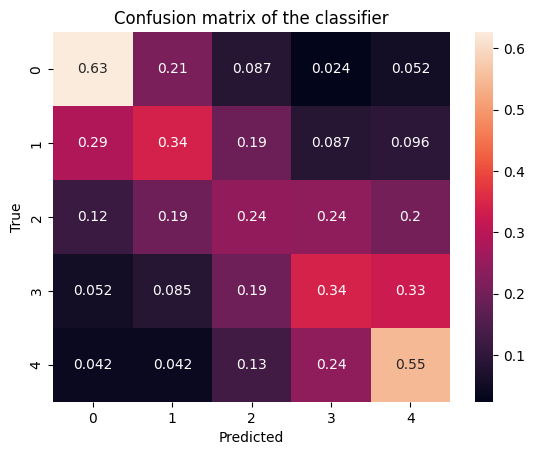

In [206]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [74]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
